In [2]:
%load_ext autoreload
%autoreload 2

import ml_utils
import numpy as np
import pickle as pkl
from tqdm import tqdm
import sklearn
import matplotlib.pyplot as plt
import gzip
import pickle as pkl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
with gzip.open("data.pkl.gz", "rb") as f:   data = pkl.load(f)

features: dict[int: dict[str: float]] = data["features"]
time_series: dict[int: dict[str: list[float]]] = data["time_series"]

pIDs: list[int] = list(features.keys())

merged: dict[int: dict[str: float | list[float]]] = {pID: {**features[pID], **time_series[pID]} for pID in pIDs}

In [4]:
X: list[np.ndarray[float]] = []
Y: list[np.ndarray[float]] = []

for t in tqdm(range(len(merged[8405]["IC"]))):

    Xt: list[np.ndarray[float]] = []
    Yt: list[np.ndarray[float]] = []

    for pID in pIDs:

        xt, yt = ml_utils.vectorize_with_nan(merged[pID], t)

        Xt.append(xt)
        Yt.append(yt)
    
    Xt: np.ndarray[float] = np.concatenate(Xt, axis=0)[None, ...]
    Yt: np.ndarray[float] = np.concatenate(Yt, axis=0)[None, ...]

    X.append(Xt)
    Y.append(Yt)

X: np.ndarray[float] = np.concatenate(X, axis=0)
Y: np.ndarray[float] = np.concatenate(Y, axis=0)

100%|██████████| 8588/8588 [04:22<00:00, 32.72it/s]


In [5]:
Xnotnan: np.ndarray[float] = ml_utils.fill_nan_with_median(X)
Xh: np.ndarray[float] = ml_utils.horizon(Xnotnan, Y, 1)

T, N, D = Xh.shape

c:\Users\33699\Python\projects\binome_med\regression\ml_utils.py:41: RuntimeWarning: All-NaN slice encountered
  nan_mask = np.isnan(X_filled[t])


In [6]:
X_train, X_test, Y_train, Y_test = ml_utils.split_by_individuals(Xh, Y, test_size=0.5)
X_train, X_test, Y_train, Y_test = X_train.reshape(-1, D), X_test.reshape(-1, D), Y_train.reshape(-1,), Y_test.reshape(T, -1)

In [7]:
model = sklearn.pipeline.Pipeline([
    ("imputer", sklearn.impute.SimpleImputer(strategy="median")),
    ("reg", sklearn.linear_model.Ridge(alpha=0))
])

model.fit(X_train, Y_train)

,steps,"[('imputer', ...), ('reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,alpha,0


In [8]:
Y_pred_train = model.predict(X_train).reshape(T, -1)
Y_pred_test = model.predict(X_test).reshape(T, -1)

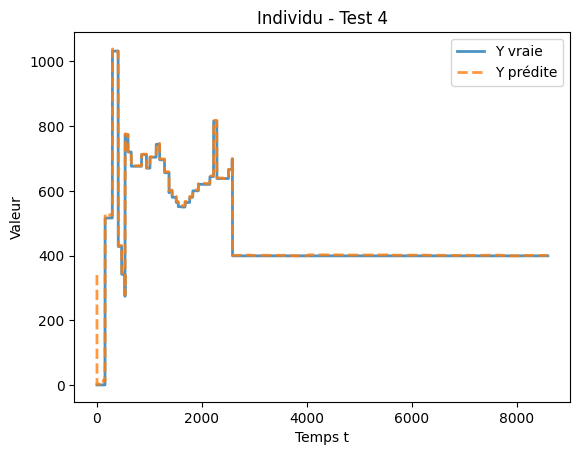

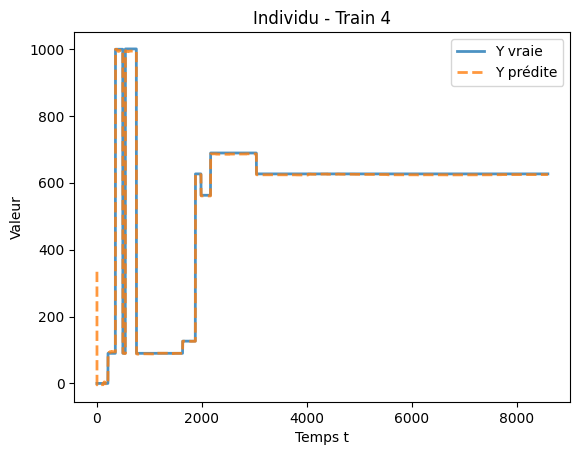

In [9]:
t = np.arange(Y_test.shape[0])
n = 4

plt.figure()
plt.plot(t, Y_test[:, n],
         label="Y vraie",
         linewidth=2,
         alpha=0.8)

plt.plot(t, Y_pred_test[:, n],
         label="Y prédite",
         linestyle="--",
         linewidth=2,
         alpha=0.8)

plt.xlabel("Temps t")
plt.ylabel("Valeur")
plt.legend()
plt.title(f"Individu - Test {n}")
plt.show()
plt.close()

plt.figure()
plt.plot(t, Y_train.reshape(T, -1)[:, n],
         label="Y vraie",
         linewidth=2,
         alpha=0.8)

plt.plot(t, Y_pred_train[:, n],
         label="Y prédite",
         linestyle="--",
         linewidth=2,
         alpha=0.8)

plt.xlabel("Temps t")
plt.ylabel("Valeur")
plt.legend()
plt.title(f"Individu - Train {n}")
plt.show()